# Deep Learing Assignment Group 8

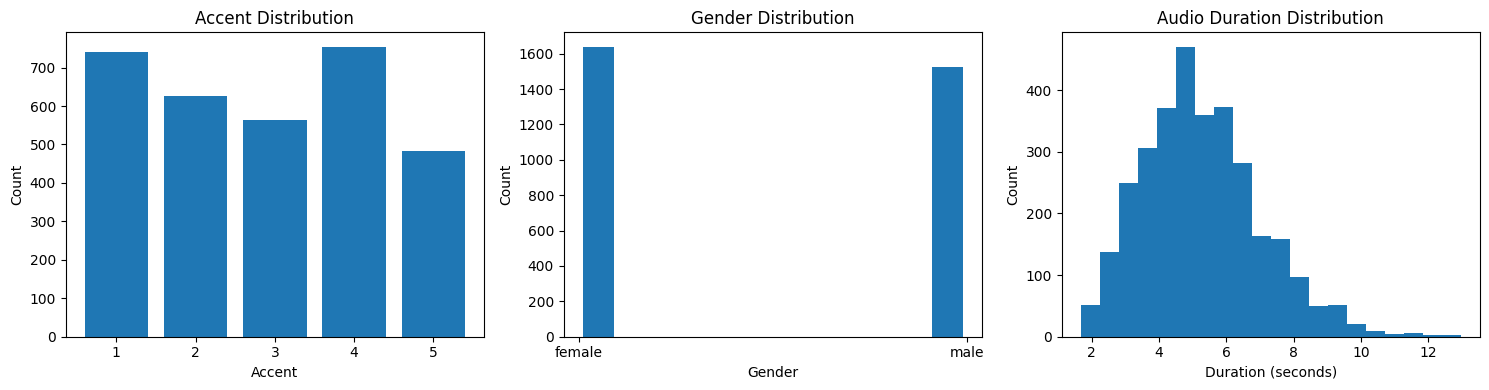

C:\Users\bilal\anaconda3\envs\ptyhon38\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


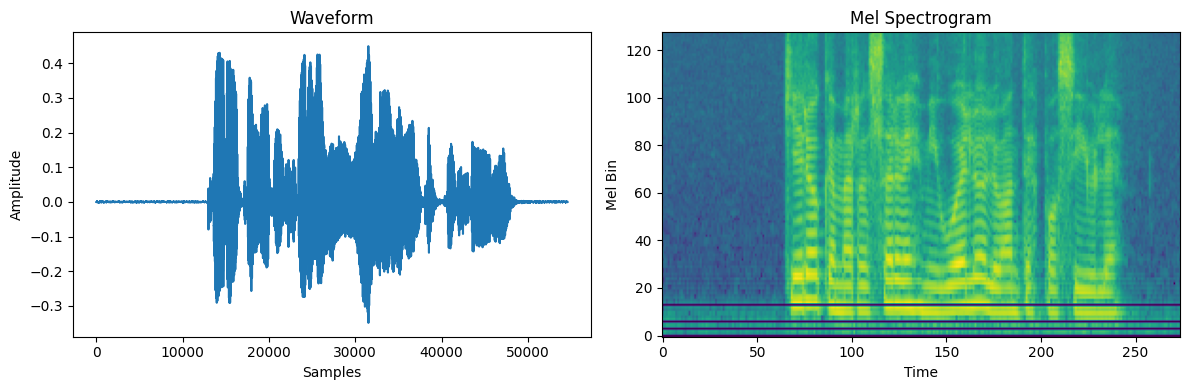

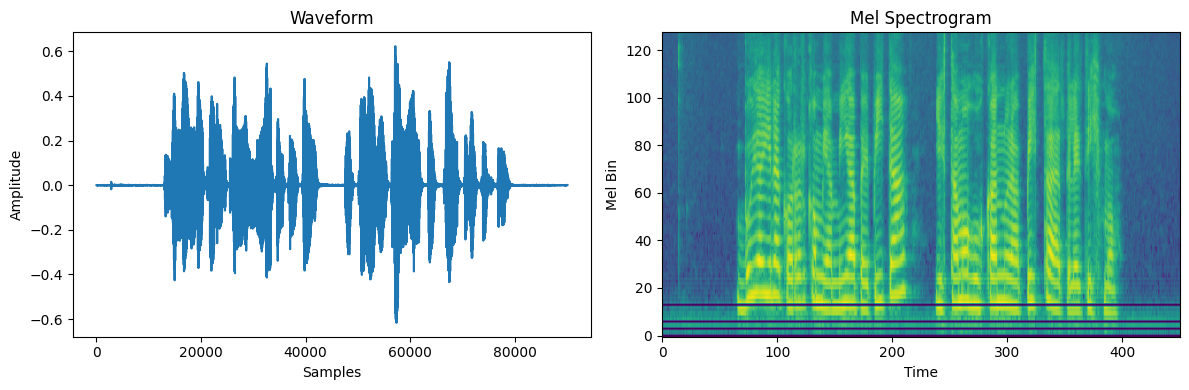

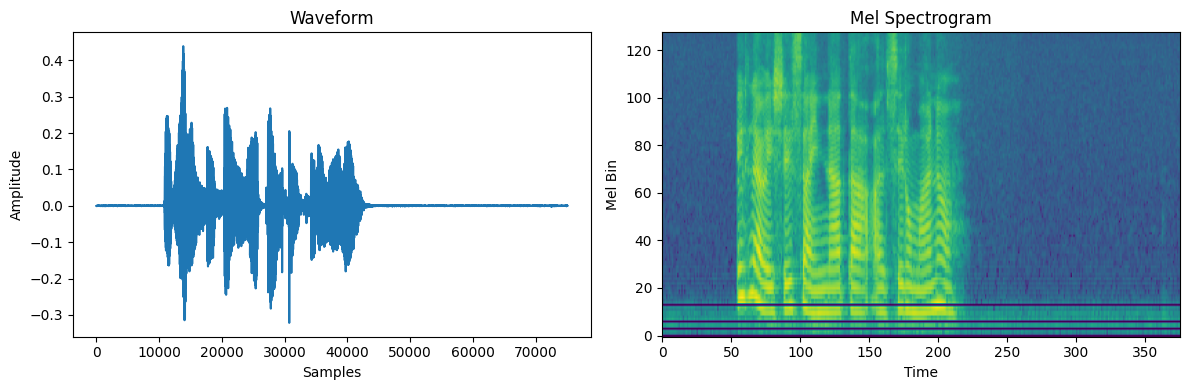

In [6]:
import os
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

SAMPLE_RATE = 16000

data_dir = r'C:\Users\bilal\Downloads\Deep learning\Train'
def list_wav_files(data_dir):
    return [f for f in os.listdir(data_dir) if f.endswith('.wav')]

# parsing metadata from filenames and audio files
def parse_metadata(data_dir, file_list):
    accents, genders, durations = [], [], []

    for fname in file_list:
        accent = int(fname[0])  # 1-5
        gender = 'male' if fname[1] == 'm' else 'female'

        path = os.path.join(data_dir, fname)
        waveform, sr = torchaudio.load(path)
        if sr != SAMPLE_RATE: #make sure equal sample sizes
            waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)
        
        duration = waveform.shape[1] / SAMPLE_RATE

        accents.append(accent)
        genders.append(gender)
        durations.append(duration)

    return accents, genders, durations

# plotting dataset statistics
def plot_dataset_stats(accents, genders, durations):
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.hist(accents, bins=np.arange(1, 7)-0.5, rwidth=0.8)
    plt.xticks(range(1, 6))
    plt.title('Accent Distribution')
    plt.xlabel('Accent')
    plt.ylabel('Count')

    plt.subplot(1, 3, 2)
    plt.hist(genders, rwidth=0.8)
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')

    plt.subplot(1, 3, 3)
    plt.hist(durations, bins=20)
    plt.title('Audio Duration Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# plotting a sample waveform and its spectrogram
def plot_sample_audio(data_dir, file_name):
    path = os.path.join(data_dir, file_name)
    waveform, sr = torchaudio.load(path)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)

    spec = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE)(waveform)
    db_spec = torchaudio.transforms.AmplitudeToDB()(spec)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(waveform.t().numpy())
    plt.title('Waveform')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')

    plt.subplot(1, 2, 2)
    plt.imshow(db_spec.squeeze().numpy(), aspect='auto', origin='lower')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Mel Bin')

    plt.tight_layout()
    plt.show()

# Main function to inspect dataset
if __name__ == "__main__":
    data_dir = r'C:\Users\bilal\Downloads\Deep learning\Train'
    file_list = list_wav_files(data_dir)

    accents, genders, durations = parse_metadata(data_dir, file_list)
    plot_dataset_stats(accents, genders, durations)
    accentcount = {}   #This was created to get the exact accent counts
    for accent in accents:
        accentcount[accent] = accentcount.get(accent, 0) + 1
    #print(accentcount)
    # Plot a few samples
    for i in range(3):
        plot_sample_audio(data_dir, file_list[i])

### RawCNN MODEL

In [2]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler

# dataset class
def pad_or_trim_waveform(waveform, target_length):
    if waveform.shape[1] < target_length:
        padding = target_length - waveform.shape[1]
        waveform = F.pad(waveform, (0, padding))
    else:
        waveform = waveform[:, :target_length]
    return waveform

class AudioDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, fixed_length=16000, transform=None):
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.fixed_length = fixed_length
        self.transform = transform
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith('.wav')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        waveform, sr = torchaudio.load(file_path)

        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        waveform = pad_or_trim_waveform(waveform, self.fixed_length)
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-9)
        label = int(file_name[0]) - 1

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label

# model class
class RawWaveformCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=5):
        super(RawWaveformCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.dropout = nn.Dropout(0.3)

        # calculating the flattened dimension
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 16000)
            dummy_out = self.conv_block(dummy_input)
            flatten_dim = dummy_out.view(1, -1).shape[1]

        self.fc = nn.Linear(flatten_dim, num_classes)

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


data_dir = r'C:\Users\joche\JupyterLab\Deep_learning\project\Train'  # TODO: Replace with your actual data folder

dataset = AudioDataset(data_dir=data_dir)

# creating balanced resampler (regularization method)
ACCENT_COUNTS = torch.tensor(list(accentcount.values()), dtype=torch.float)
samples_per_class = 1.0 / ACCENT_COUNTS
all_labels = [label for _, label in dataset]
labels_tensor = torch.tensor(all_labels)
sample_weights = samples_per_class[labels_tensor]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RawWaveformCNN().to(device)

# printing model summary
print(model)

# creating class-weighted loss
accent_counts = torch.tensor(list(accentcount.values()), dtype=torch.float, device=device)
class_weights = (1.0/accent_counts)
class_weights = class_weights/class_weights.sum()

# simple Training Loop Template
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss(weight = class_weights)

# checking sampler produces balanced batch
x, y = next(iter(dataloader))
print("Batch class histogram:", torch.bincount(y, minlength=5))

# checking weighted loss
print("Loss weights:", criterion.weight.cpu().numpy())

num_epochs = 10

train_loss = []
train_acc = []


for epoch in range(num_epochs):
    # regenerating sampler with reshuffled sample weights
    all_labels = [label for _, label in dataset]
    labels_tensor = torch.tensor(all_labels)
    sample_weights = samples_per_class[labels_tensor]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # regenerating dataloader with new sampler
    dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # tracking metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataset)
    epoch_acc = 100 * correct / total
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {epoch_loss:.4f}  Accuracy: {epoch_acc:.2f}%")


RawWaveformCNN(
  (conv_block): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32000, out_features=5, bias=True)
)
Batch class histogram: tensor([ 3,  5,  5, 11,  8])
Loss weights: [0.16

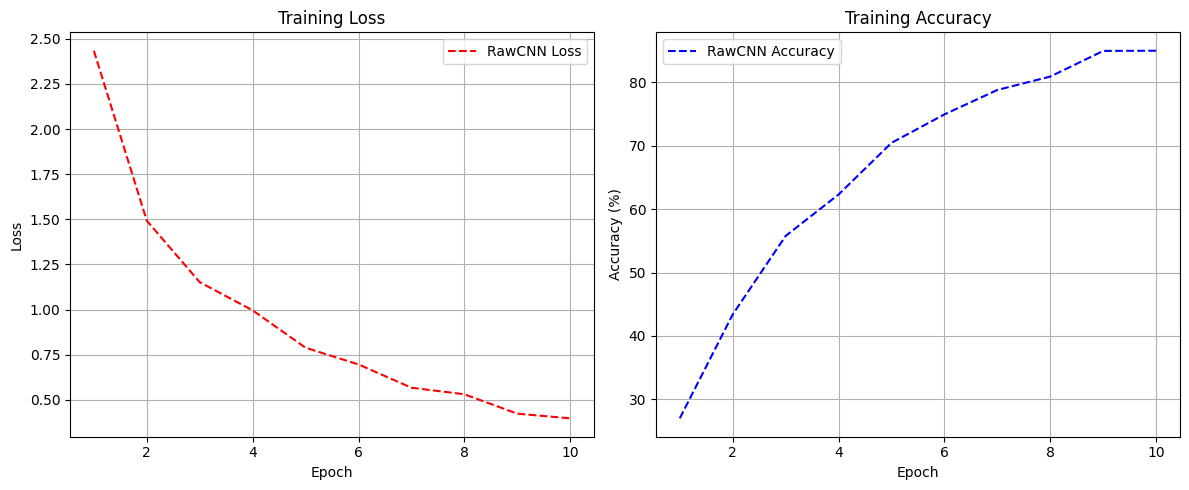

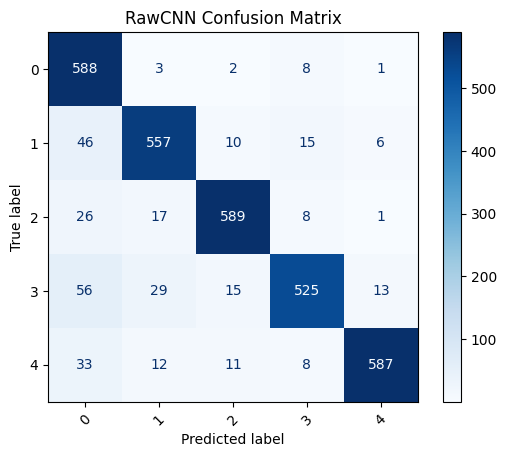

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Training Accuracy & Loss curves (RawCNN vs MelCNN)
epochs = list(range(1, len(train_acc) + 1))
raw_train_loss = train_loss 

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, raw_train_loss, label='RawCNN Loss', color='red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='RawCNN Accuracy', color='blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Confusion Matrix Comparison Function
def evaluate_confusion(model, dataloader, device, title):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(title)
    plt.show()


evaluate_confusion(model, dataloader, device, "RawCNN Confusion Matrix")

In [4]:
# switch model to eval mode and evaluate on validation/test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
total_f1 = 0

print(f"Accuracy: {accuracy:.4f}")
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {i+1}: Precision={p:.4f}, Recall={r:.4f}, F1-Score={f:.4f}")
    total_f1 += round(f, 4)

print(f"F1-score across all accents: {total_f1/5:.4f}")


Accuracy: 0.9008
Class 1: Precision=0.7818, Recall=0.9663, F1-Score=0.8643
Class 2: Precision=0.9160, Recall=0.8797, F1-Score=0.8975
Class 3: Precision=0.9458, Recall=0.9100, F1-Score=0.9275
Class 4: Precision=0.9298, Recall=0.8432, F1-Score=0.8844
Class 5: Precision=0.9648, Recall=0.9069, F1-Score=0.9350
F1-score across all accents: 0.9017


In [5]:
# --- competition test ---
class TestDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, fixed_length=16000):
        self.data_dir = data_dir
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith('.wav')]
        self.sample_rate = sample_rate
        self.fixed_length = fixed_length

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        waveform, sr = torchaudio.load(file_path)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        waveform = pad_or_trim_waveform(waveform, self.fixed_length)
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-9)
        return waveform, file_name

test_data_dir = r'C:\Users\joche\Downloads\Test_set\Test set'  # <-- change this to your actual test folder

test_dataset = TestDataset(test_data_dir)
test_loader = DataLoader(test_dataset, batch_size=32)

model.eval()
predictions = []

with torch.no_grad():
    for inputs, file_names in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy() + 1  # Add 1 for labels 1–5
        for fname, pred in zip(file_names, preds):
            file_id = os.path.splitext(fname)[0]
            predictions.append((int(file_id), int(pred)))

# saving predictions to CSV
import pandas as pd
submission_df = pd.DataFrame(predictions, columns=['Id', 'label'])
submission_df = submission_df.sort_values(by='Id')  # optional
submission_df.to_csv('submission_rawCNN.csv', index=False)

print("Submission file saved as 'submission_rawCNN.csv'")

Submission file saved as 'submission_rawCNN.csv'


**RawCNN Training Performance:**

**Loss:** Starts at 2.434 and drops steadily to 0.397

**Accuracy:** Starts at 27.01%, ends at 85.00% after 10 epochs and peaks at 90.08% on the evaluation set.

The model improves consistently and reaches high accuracy using only raw audio.

**Strengths:**

- Very strong final accuracy (90.08%) without any feature transformation.

- Learns fast → jumps from 27.01% to 70.47% in just 5 epochs.

- Training loss steadily decreases, no instability.

- Works directly on raw waveform → no need for spectrograms.

- Confusion matrix shows most predictions are correct.

**Weaknesses:**

- Slightly slower improvement compared to MelCNN at the start.

- Needs more compute due to high input size (raw waveform = 16000 values).

- Class 1 is often misclassified as class 0 (46 instances) and class 3 (15 instances). Class 3 is commonly misclassified as class 0 (56 instances) and class 1 (29 instances). Class 2 is sometimes misclassified as class 1 (17 instances) and class 3 (8 instances).




In [6]:
class AudioDataset(Dataset): 
    def __init__(self, data_dir, sample_rate=16000, fixed_length=16000, transform=None):
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.fixed_length = fixed_length
        self.transform = transform
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith('.wav')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        waveform, sr = torchaudio.load(file_path)

        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        waveform = pad_or_trim_waveform(waveform, self.fixed_length)
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-9)

        label = int(file_name[0]) - 1
        gender = 0 if file_name[1] == 'm' else 1 

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label, gender# added gender


In [7]:
dataset = AudioDataset(data_dir=data_dir)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [8]:
all_preds, all_labels, all_genders = [], [], []

model.eval()
with torch.no_grad():
    for x, y, gender in dataloader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.numpy())
        all_genders.extend(gender.numpy())


In [9]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_genders = np.array(all_genders)

for gender_id, gender_name in zip([0, 1], ['Male', 'Female']):
    mask = all_genders == gender_id
    preds = all_preds[mask]
    labels = all_labels[mask]

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    print(f"{gender_name} — Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Male — Accuracy: 0.9136, Precision: 0.9128, Recall: 0.9222, F1: 0.9144
Female — Accuracy: 0.8877, Precision: 0.9050, Recall: 0.8776, F1: 0.8889


### MelCNN MODEL

In [10]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MelSpectrogramDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, n_mels=128, fixed_length=256, transform=None):
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.fixed_length = fixed_length
        self.transform = transform
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith('.wav')]
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=128,
            n_mels=n_mels
        )

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        waveform, sr = torchaudio.load(file_path)

        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        mel_spec = self.mel_transform(waveform)
        mel_spec = torch.log(mel_spec + 1e-9)
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-9)

        if mel_spec.shape[2] < self.fixed_length:
            pad = self.fixed_length - mel_spec.shape[2]
            mel_spec = F.pad(mel_spec, (0, pad))
        else:
            mel_spec = mel_spec[:, :, :self.fixed_length]

        label = int(file_name[0]) - 1
        return mel_spec, label

class MelCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(MelCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 256)
            out = self.features(dummy)
            flat_dim = out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(flat_dim, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# loading dataset and model

DATA_PATH = r'C:\Users\joche\JupyterLab\Deep_learning\project\Train'
dataset = MelSpectrogramDataset(DATA_PATH)

# creating balanced resampler (regularization method)
ACCENT_COUNTS = torch.tensor(list(accentcount.values()), dtype=torch.float)
samples_per_class = 1.0 / ACCENT_COUNTS
all_labels = [label for _, label in dataset]
labels_tensor = torch.tensor(all_labels)
sample_weights = samples_per_class[labels_tensor]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MelCNN().to(device)
print(model)


# creating class-weighted loss
accent_counts = torch.tensor(list(accentcount.values()), dtype=torch.float, device=device)
class_weights = (1.0/accent_counts)
class_weights = class_weights/class_weights.sum()

# training loop
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss(weight = class_weights)

# checking sampler produced balanced batch
x, y = next(iter(dataloader))
print("Batch class histogram:", torch.bincount(y, minlength=5))

# checking weighted loss
print("Loss weights:", criterion.weight.cpu().numpy())

num_epochs = 10

train_loss = []
train_acc = []

for epoch in range(num_epochs):
    # regenerating sampler with reshuffled sample weights
    all_labels = [label for _, label in dataset]
    labels_tensor = torch.tensor(all_labels)
    sample_weights = samples_per_class[labels_tensor]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # regeneraating dataloader with new sampler
    dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataset)
    epoch_acc = 100. * correct / total
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.2f}%")

MelCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=65536, out_features=5, bias=True)
  )
)
Batch class histogram: tensor([5, 8, 6, 7, 6])
Loss weights: [0.16636536 0.1966619  0.21828076 0.16327633 0.2554157 ]
Epoch [1/10] Loss: 5.1556 Accuracy: 40.97%
Epoch [2/10] Loss: 1.4936 Accuracy: 64.78%
Epoch [3/10] Loss: 0.9900 Accuracy: 76.41%
Epoch [4/10] Loss: 0.6062 Accuracy: 83.83%
Epoch [5/1

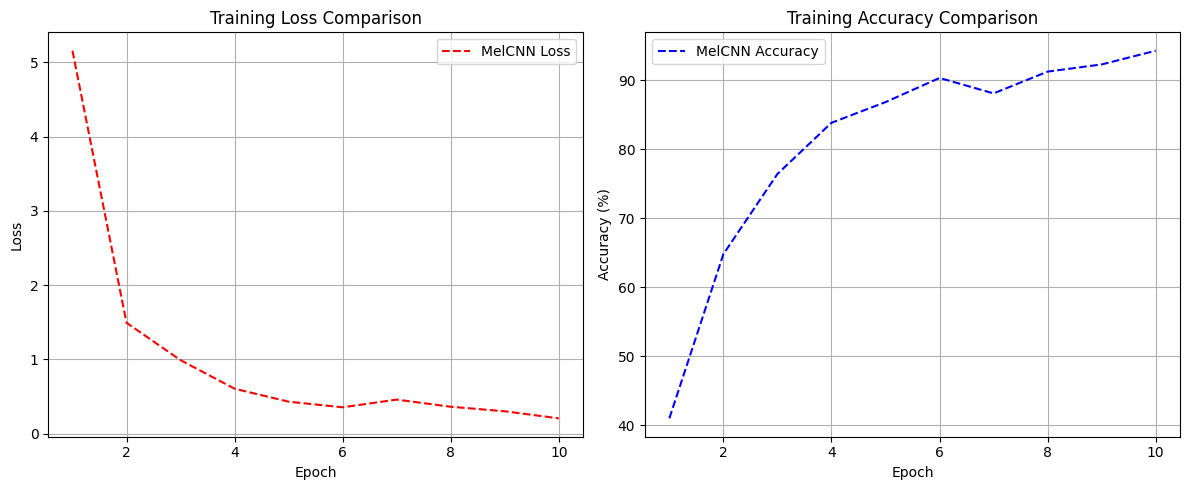

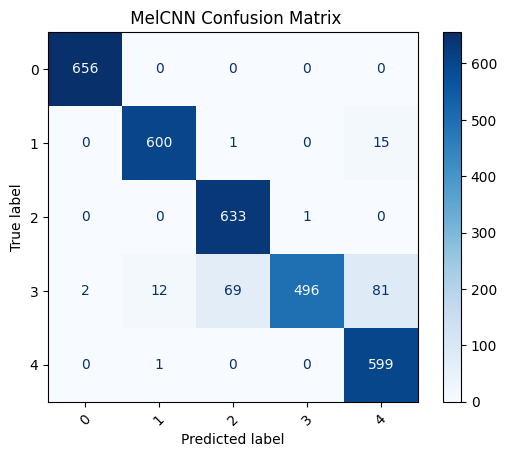

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Training Accuracy & Loss curves (RawCNN vs MelCNN)
epochs = list(range(1, len(train_acc) + 1))
raw_train_loss = train_loss 

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, raw_train_loss, label='MelCNN Loss', color='red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='MelCNN Accuracy', color='blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Confusion Matrix Comparison Function
def evaluate_confusion(model, dataloader, device, title):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(title)
    plt.show()

evaluate_confusion(model, dataloader, device, " MelCNN Confusion Matrix")

In [11]:
# switch model to eval mode and evaluate on validation/test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)

total_f1 = 0

print(f"Accuracy: {accuracy:.4f}")
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {i+1}: Precision={p:.4f}, Recall={r:.4f}, F1-Score={f:.4f}")
    total_f1 += round(f, 4)

print(f"F1-score across all accents: {total_f1/5:.4f}")


Accuracy: 0.9564
Class 1: Precision=0.9967, Recall=1.0000, F1-Score=0.9984
Class 2: Precision=0.9906, Recall=0.9768, F1-Score=0.9837
Class 3: Precision=0.9253, Recall=1.0000, F1-Score=0.9612
Class 4: Precision=1.0000, Recall=0.7967, F1-Score=0.8868
Class 5: Precision=0.8945, Recall=1.0000, F1-Score=0.9443
F1-score across all accents: 0.9549


In [12]:
import os
import torch
import torchaudio
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# --- competition test (Mel spectrogram version) ---
class MelTestDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, n_mels=128, fixed_length=256):
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.fixed_length = fixed_length
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith('.wav')]
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=128,
            n_mels=n_mels
        )

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        waveform, sr = torchaudio.load(file_path)

        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        mel_spec = self.mel_transform(waveform)
        mel_spec = torch.log(mel_spec + 1e-9)
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-9)

        if mel_spec.shape[2] < self.fixed_length:
            pad = self.fixed_length - mel_spec.shape[2]
            mel_spec = F.pad(mel_spec, (0, pad))
        else:
            mel_spec = mel_spec[:, :, :self.fixed_length]

        return mel_spec, file_name

test_data_dir = r'C:\Users\joche\Downloads\Test_set\Test set'  # <-- change to your test folder
test_dataset = MelTestDataset(test_data_dir)
test_loader = DataLoader(test_dataset, batch_size=32)

# running inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
predictions = []

with torch.no_grad():
    for inputs, file_names in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy() + 1  # 1–5 labels
        for fname, pred in zip(file_names, preds):
            file_id = os.path.splitext(fname)[0]
            predictions.append((int(file_id), int(pred)))

# saving predictions to CSV
submission_df = pd.DataFrame(predictions, columns=['Id', 'label'])
submission_df = submission_df.sort_values(by='Id')
submission_df.to_csv('submission_melCNN.csv', index=False)
print("Submission file saved as 'submission_melCNN.csv'")


Submission file saved as 'submission_melCNN.csv'


**MelCNN Training Performance**:

**Loss**: Starts very high at 5.156 and drops rapidly to 0.207. 

**Accuracy**: Starts at 40.97%, ends at 94.28% after 10 epochs and peaks at 95.64% on the evaluation set.

Indicates the model learns quickly after initial stabilization


**Strengths:**

- Very high final accuracy (95.64%) → The model is clearly able to learn accent features well.

- Fast improvement after epoch 2 → Accuracy jumped from 40.97% → 83.83% in just 4 epochs.

- Loss decreased sharply → From 5.156 to 0.207, meaning the model learned quickly and confidently.

- Consistent improvement every epoch(except minor fluctations at epoch 5 and 8 ) → No signs of overfitting or sudden drops.

- Confusion matrix shows most predictions correct → Strong per-class performance.

**Weaknesses:**
- Extremely high loss at start (5.156) → indicates unstable initialization, possibly due to input scale or weights.

- Some confusion between similar accents (as seen in confusion matrix) → Model mixes some classes:

- Class 3 is confused with class 2 (69 times) and class 4 (81 times).

- Minor misclassification for class 1 to class 4 (15 times).


In [14]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, n_mels=128, fixed_length=256, transform=None):
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.fixed_length = fixed_length
        self.transform = transform
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith('.wav')]

        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=128,
            n_mels=n_mels
        )

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        waveform, sr = torchaudio.load(file_path)

        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        mel_spec = self.mel_transform(waveform)
        mel_spec = torch.log(mel_spec + 1e-9)
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-9)

        if mel_spec.shape[2] < self.fixed_length:
            pad = self.fixed_length - mel_spec.shape[2]
            mel_spec = F.pad(mel_spec, (0, pad))
        else:
            mel_spec = mel_spec[:, :, :self.fixed_length]

        label = int(file_name[0]) - 1
        gender = 0 if file_name[1] == 'm' else 1  

        return mel_spec, label, gender  # added gender

In [15]:
dataset = MelSpectrogramDataset(data_dir=data_dir)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MelCNN().to(device)

all_preds, all_labels, all_genders = [], [], []

model.eval()
with torch.no_grad():
    for x, y, gender in dataloader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.numpy())
        all_genders.extend(gender.numpy())

In [17]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_genders = np.array(all_genders)

for gender_id, gender_name in zip([0, 1], ['Male', 'Female']):
    mask = all_genders == gender_id
    preds = all_preds[mask]
    labels = all_labels[mask]

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    print(f"{gender_name} — Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


Male — Accuracy: 0.1958, Precision: 0.2650, Recall: 0.2058, F1: 0.1416
Female — Accuracy: 0.2148, Precision: 0.1211, Recall: 0.1967, F1: 0.1352


# Performance Evaluation

### Accent performance RawCNN vs MelCNN
 
**MelCNN**
 - Class 1 (F1 = 0.9984) and Class 2 (F1 = 0.9837) have the highest F1-scores, meaning the model recognizes these accents most accurately.
 - Class 4 (F1 = 0.8868) has the lowest F1-score, meaning it's the hardest for the model to classify correctly.
 - Class 5 also performs well (F1 = 0.9443), although slightly lower than the best classes.
 - Class 3 shows excellent recall (1.0000) but slightly lower precision (0.9253), reducing its F1-score to 0.9612.
 
**RawCNN:**
- Class 1 performs the worst (F1 = 0.8643), with notably lower precision (0.7818) despite high recall (0.9663).
- Class 5 performs the best (F1 = 0.9350), showing strong performance across both precision and recall.
- Class 2 and Class 4 also show slightly reduced F1-scores (0.8975 and 0.8844 respectively), indicating difficulty with some accent distinctions.
 
Overall, RawCNN has slightly lower consistency in F1 across classes compared to MelCNN.
 
**Potential reasons:**
- Data imbalance: some accents might be better represented, which leads to better bias and better performance on these classes.
- some accents might be similar in e.g intonation, which makes it harder to distinguish, especially for RawCNN.
- MelCNN might be better at picking discriminative features compared to RawCNN, which may miss some sound differences between the accents.
 
`Conclusion:` MellCNN performs better across all accents compared to RawCNN. So variations in accents does affect the classification.

**Gender Results  RawCNN vs MelCNN:**

RawCNN shows concistent high and balanced performance for both male and female speakers (F1 = 0.914 and 0.888). Since there is a very small difference between these groups, we can conclude that RawCNN has no signficant gender bias in its predictions.

MelCNN, has very poor performance for both genders (F1 = 0.141 and 0.135). This could mean that the model failed to generalize these groups. This does not indicate gender bias, but rather that the model struggles to generalize across the gender of the speakers, likely due to limitations in the mel-spectrogram representation.

`Conlcusion:` there is no evidence of gender bias in both models.



# Data Augmentation

In [2]:
!pip install audiomentations==0.27.0

from audiomentations import Compose, AddGaussianNoise, PitchShift, Shift

audio_transform = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.3),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.3),
    Shift(p=0.3)])

### RawCNN

In [7]:
# Install and import libraries
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler

# dataset class
def pad_or_trim_waveform(waveform, target_length):
    if waveform.shape[1] < target_length:
        padding = target_length - waveform.shape[1]
        waveform = F.pad(waveform, (0, padding))
    else:
        waveform = waveform[:, :target_length]
    return waveform

class AudioDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, fixed_length=16000, transform=None):
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.fixed_length = fixed_length
        self.transform = transform
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith('.wav')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        waveform, sr = torchaudio.load(file_path)

        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        waveform = pad_or_trim_waveform(waveform, self.fixed_length)
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-9)
        label = int(file_name[0]) - 1

        if self.transform:
          waveform_np = waveform.squeeze(0).numpy()
          augmented_np = self.transform(samples=waveform_np, sample_rate=self.sample_rate)
          waveform = torch.tensor(augmented_np, dtype=torch.float32).unsqueeze(0)


        return waveform, label

# model class
class RawWaveformCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=5):
        super(RawWaveformCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.dropout = nn.Dropout(0.3)

      
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 16000)
            dummy_out = self.conv_block(dummy_input)
            flatten_dim = dummy_out.view(1, -1).shape[1]

        self.fc = nn.Linear(flatten_dim, num_classes)

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)



data_dir = r'C:\Users\bilal\Downloads\Deep learning\Train'   

dataset = AudioDataset(data_dir=data_dir, transform=audio_transform)

# creating balanced resampler (regularization method)
ACCENT_COUNTS = torch.tensor(list(accentcount.values()), dtype=torch.float)
samples_per_class = 1.0 / ACCENT_COUNTS
all_labels = [label for _, label in dataset]
labels_tensor = torch.tensor(all_labels)
sample_weights = samples_per_class[labels_tensor]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RawWaveformCNN().to(device)

# printing model summary
print(model)

# creating class-weighted loss
accent_counts = torch.tensor(list(accentcount.values()), dtype=torch.float, device=device)
class_weights = (1.0/accent_counts)
class_weights = class_weights/class_weights.sum()

# Simple Training Loop Template
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss(weight = class_weights)

# check sampler produces balanced batch
x, y = next(iter(dataloader))
print("Batch class histogram:", torch.bincount(y, minlength=5))

# check weighted loss
print("Loss weights:", criterion.weight.cpu().numpy())

num_epochs = 15

train_loss = []
train_acc = []

for epoch in range(num_epochs):
    # Regenerate sampler with reshuffled sample weights
    all_labels = [label for _, label in dataset]
    labels_tensor = torch.tensor(all_labels)
    sample_weights = samples_per_class[labels_tensor]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # regenerating dataloader with new sampler
    dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # tracking metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataset)
    epoch_acc = 100 * correct / total

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {epoch_loss:.4f}  Accuracy: {epoch_acc:.2f}%")

RawWaveformCNN(
  (conv_block): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32000, out_features=5, bias=True)
)
Batch class histogram: tensor([8, 7, 7, 3, 7])
Loss weights: [0.1663653

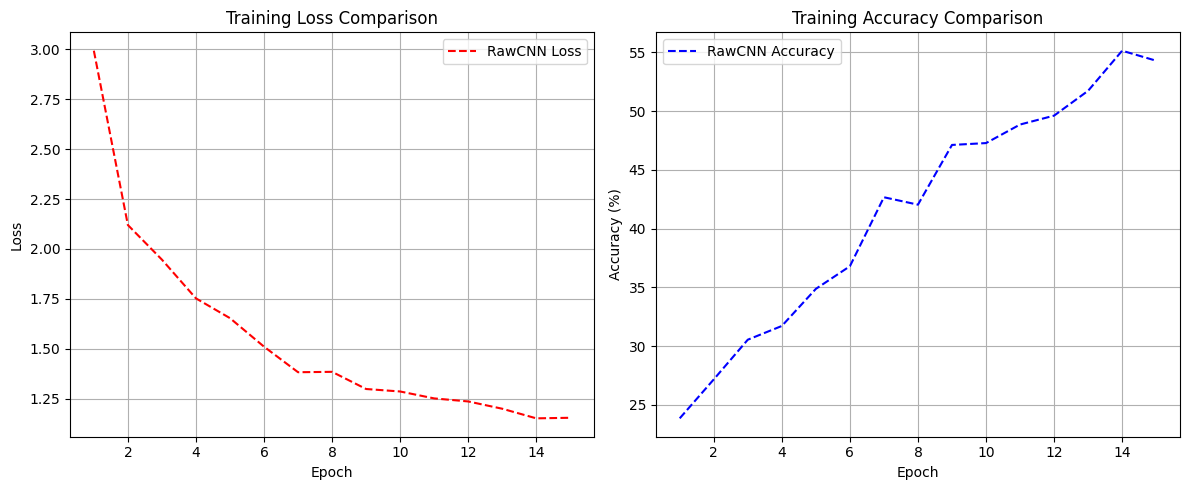

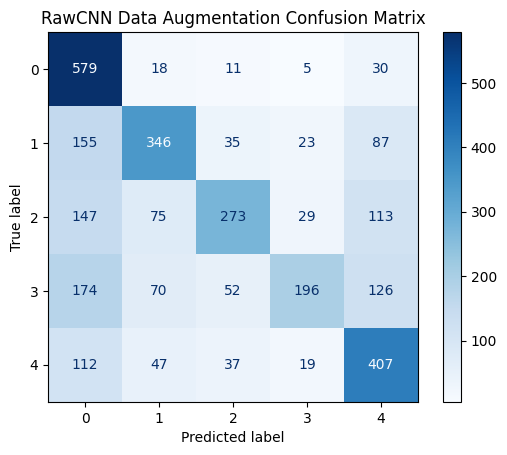

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Training Accuracy & Loss curves (RawCNN vs MelCNN)
epochs = list(range(1, len(train_acc) + 1))
raw_train_loss = train_loss

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, raw_train_loss, label='RawCNN Loss', color='red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='RawCNN Accuracy', color='blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
def evaluate_confusion(model, dataloader, device, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.grid(False)
    plt.show()
evaluate_confusion(model, dataloader, device, "RawCNN Data Augmentation Confusion Matrix")

### MelCNN

In [10]:
from audiomentations import Compose, AddGaussianNoise, PitchShift, Gain

audio_transform = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    Gain( p=0.5)])

In [ ]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MelSpectrogramDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, n_mels=128, fixed_length=256, transform=None):
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.fixed_length = fixed_length
        self.transform = transform
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith('.wav')]
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=128,
            n_mels=n_mels
        )

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        waveform, sr = torchaudio.load(file_path)

        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        if self.transform:
          waveform_np = waveform.squeeze(0).numpy()
          augmented = self.transform(samples=waveform_np, sample_rate=self.sample_rate)
          waveform = torch.tensor(augmented).unsqueeze(0)

        mel_spec = self.mel_transform(waveform)
        mel_spec = torch.log(mel_spec + 1e-9)
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-9)

        if mel_spec.shape[2] < self.fixed_length:
            pad = self.fixed_length - mel_spec.shape[2]
            mel_spec = F.pad(mel_spec, (0, pad))
        else:
            mel_spec = mel_spec[:, :, :self.fixed_length]

        label = int(file_name[0]) - 1
        return mel_spec, label

class MelCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(MelCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 256)
            out = self.features(dummy)
            flat_dim = out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(flat_dim, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


DATA_PATH = r'C:\Users\bilal\Downloads\Deep learning\Train' 
dataset = MelSpectrogramDataset(DATA_PATH, transform=audio_transform)

# creating balanced resampler (regularization method)
ACCENT_COUNTS = torch.tensor(list(accentcount.values()), dtype=torch.float)
samples_per_class = 1.0 / ACCENT_COUNTS
all_labels = [label for _, label in dataset]
labels_tensor = torch.tensor(all_labels)
sample_weights = samples_per_class[labels_tensor]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MelCNN().to(device)
print(model)


# creating class-weighted loss
accent_counts = torch.tensor(list(accentcount.values()), dtype=torch.float, device=device)
class_weights = (1.0/accent_counts)
class_weights = class_weights/class_weights.sum()

# training loop
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss(weight = class_weights)

# checking sampler produced balanced batch
x, y = next(iter(dataloader))
print("Batch class histogram:", torch.bincount(y, minlength=5))

# checking weighted loss
print("Loss weights:", criterion.weight.cpu().numpy())

num_epochs = 15

train_loss = []
train_acc = []
for epoch in range(num_epochs):
    # regenerating sampler with reshuffled sample weights
    all_labels = [label for _, label in dataset]
    labels_tensor = torch.tensor(all_labels)
    sample_weights = samples_per_class[labels_tensor]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # regenerating dataloader with new sampler
    dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataset)
    epoch_acc = 100. * correct / total
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.2f}%")

MelCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=65536, out_features=5, bias=True)
  )
)
Batch class histogram: tensor([9, 2, 8, 7, 6])
Loss weights: [0.16636536 0.1966619  0.21828076 0.16327633 0.2554157 ]
Epoch [1/15] Loss: 9.1261 Accuracy: 30.10%
Epoch [2/15] Loss: 2.9609 Accuracy: 38.91%
Epoch [3/15] Loss: 2.2163 Accuracy: 46.65%
Epoch [4/15] Loss: 1.8425 Accuracy: 49.94%


**We did run this one time already with only the initial batch class histogram, but we did not have the time left to run each epoch with different batch class histogram. So below are the results from first time running.**

**Below the evaluation from run 1**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Training Accuracy & Loss curves (RawCNN vs MelCNN)
epochs = list(range(1, len(train_acc) + 1))
raw_train_loss = train_loss

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, raw_train_loss, label='MelCNN Loss', color='red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='MelCNN Accuracy', color='blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

evaluate_confusion(model, dataloader, device, "MelCNN Data Augmentation Confusion Matrix")

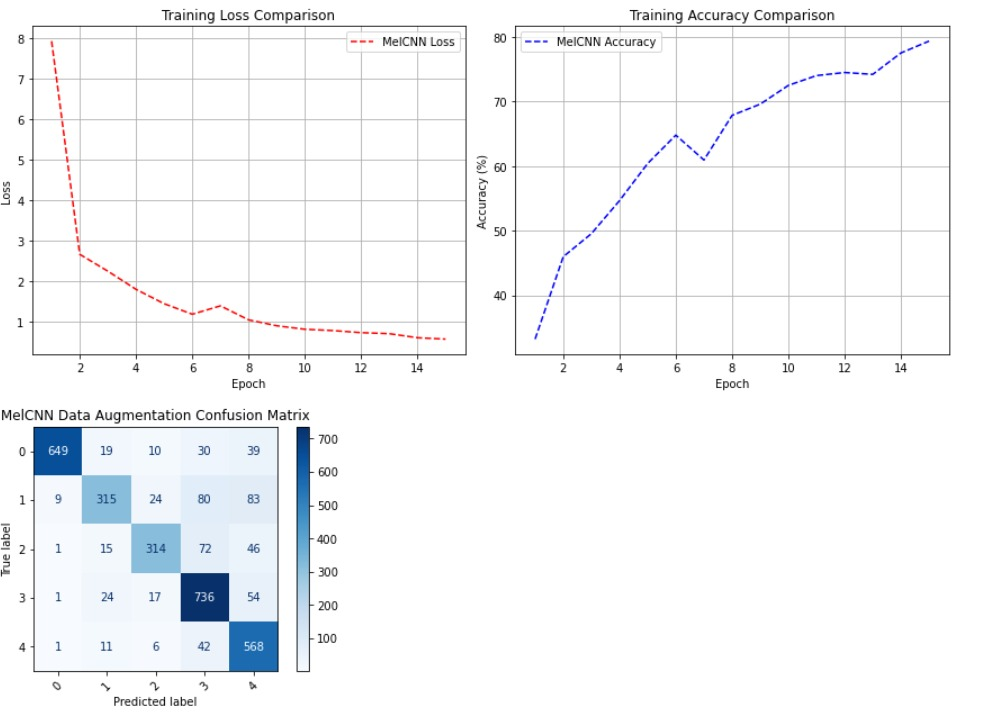

In [6]:
from PIL import Image
import IPython.display as display

# Local image path
image_path = r'C:\Users\bilal\Downloads\Deep learning\bilo.jpg'

# Load and display in notebook
img = Image.open(image_path)
display.display(img)


**Raw CNN:**

For the raw CNN, the data augmentation technique does not seem to improve. In comparison with the regularized model, the performance on training stays behind a lot. Even when lowering the p-value to p=0.3, to make the augmentation less strong, it seems to not change the generalization much.